In [1]:
import itertools
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import time

%matplotlib inline

In [2]:
def make_random_graph_list(V_size, E_size):
    network_list = np.array([np.random.choice(range(V_size),2,replace=False) for i in range(E_size)])
    network_list = np.unique(network_list, axis=0)
    weighted = np.random.uniform(0,1,len(network_list))
    
    # from to と　weightedを連結
    return np.vstack([network_list.T, weighted]).T

In [3]:
# def compute_MIOA_(v, G_table):
#     MIOA = nx.DiGraph()
#     for u_path in G_table[v][1].values():
#         nx.add_path(MIOA, u_path)
#     return MIOA

# theta = 0.00001
# G_table = compute_MIP_G(G, theta)

# MIOA = compute_MIOA(0, G_table)
# # nx.draw_networkx(MIOA)

In [4]:
# def compute_MIIA_(v, G_table, G):
#     MIIA = nx.DiGraph()
#     for node in G:
#         if (node not in MIIA) and (v in G_table[node][1]):
#             nx.add_path(MIIA, G_table[node][1][v])
#     return MIIA


# # 試行錯誤したが、遅い。。。やはり自作か。
# def compute_MIIA_osoi(v, G_table, G):
#     MIIA = nx.DiGraph()
#     for node in G:
#         if not node in MIIA:
#             path = G_table[node][1].get(v)
#             if path:
#                 nx.add_path(MIIA, path)
#     return MIIA

# def compute_MIIA_kai(v, G_path):
#     MIIA = nx.DiGraph()
#     for n, (dist, path) in tqdm(G_path):
#         path_v = path.get(v)
#         if path_v:
#             nx.add_path(MIIA, path_v)
#     return MIIA

# # theta = 0.00001
# # G_table = compute_MIP_G(G, theta)

# # MIIA = compute_MIIA(2, G_table)
# # # nx.draw_networkx(MIIA)

In [5]:
def compute_MIIA(v, theta, G):

    MIIA = nx.DiGraph()
    MIIA.add_node(v)
    MIIA_MIP = {v: [v]}

    crossing_edges = set([in_edge for in_edge in G.in_edges([v])])
    edge_weights = dict()
    dist = {v: 0} # shortest paths from the root u

    # grow MIIA
    while crossing_edges:
        # Dijkstra's greedy criteria
        min_dist = float("Inf")
        sorted_crossing_edges = sorted(crossing_edges) # to break ties consistently
        for edge in sorted_crossing_edges:
            if edge not in edge_weights:
                edge_weights[edge] = -np.log(G[edge[0]][edge[1]]["weight"])
            edge_weight = edge_weights[edge]
            # 更新条件
            if dist[edge[1]] + edge_weight < min_dist:
                min_dist = dist[edge[1]] + edge_weight
                min_edge = edge
        # check stopping criteria
        if min_dist < -np.log(theta):
            dist[min_edge[0]] = min_dist
            MIIA.add_edge(min_edge[0], min_edge[1])
            MIIA_MIP[min_edge[0]] = MIIA_MIP[min_edge[1]] + [min_edge[0]]
            # update crossing edges
            crossing_edges.difference_update(G.out_edges(min_edge[0]))
            crossing_edges.update([in_edge for in_edge in G.in_edges(min_edge[0]) if (in_edge[0] not in MIIA)])
        else:
            break
    return MIIA, MIIA_MIP

In [6]:
def compute_MIOA(v, theta, G):

    MIOA = nx.DiGraph()
    MIOA.add_node(v)
    MIOA_MIP = {v: [v]}

    crossing_edges = set([out_edge for out_edge in G.out_edges([v])])
    edge_weights = dict()
    dist = {v: 0} # shortest paths from the root u

    # grow MIOA
    while crossing_edges:
        # Dijkstra's greedy criteria
        min_dist = float("Inf")
        sorted_crossing_edges = sorted(crossing_edges) # to break ties consistently
        for edge in sorted_crossing_edges:
            if edge not in edge_weights:
                edge_weights[edge] = -np.log(G[edge[0]][edge[1]]["weight"])
            edge_weight = edge_weights[edge]
            # 更新条件
            if dist[edge[0]] + edge_weight < min_dist:
                min_dist = dist[edge[0]] + edge_weight
                min_edge = edge
        # check stopping criteria
        if min_dist < -np.log(theta):
            dist[min_edge[1]] = min_dist
            MIOA.add_edge(min_edge[0], min_edge[1])
            MIOA_MIP[min_edge[1]] = MIOA_MIP[min_edge[0]] + [min_edge[1]]
            # update crossing edges
            crossing_edges.difference_update(G.in_edges(min_edge[1]))
            crossing_edges.update([out_edge for out_edge in G.out_edges(min_edge[1]) if (out_edge[1] not in MIOA)])
        else:
            break
    return MIOA, MIOA_MIP

In [7]:
def compute_ap(ap, S, MIIA_v, MIIA_MIP_v, G):
    # MIIAtreeの末端から計算すれば、効率的になるため、ソート
    sorted_path_len = sorted(MIIA_MIP_v.items(), key=lambda x:len(x[1]), reverse=True)
    
    for u, _ in sorted_path_len:
        if u in S:
            ap[(u, MIIA_v)] = 1
        else:
            N_in = MIIA_v.in_edges([u])
            if not N_in:
                ap[(u, MIIA_v)] = 0
            else:
                prod = 1
                for w, _ in N_in:
                    prod *= 1 - ap[(w, MIIA_v)] * G[w][u]["weight"]
                ap[(u, MIIA_v)] = 1 - prod

In [8]:
def compute_alpha(alpha, v, MIIA_v, MIIA_MIP_v, S, G, ap):
    # 木のルートからはじめると効率的に計算できる
    sorted_path_len = sorted(MIIA_MIP_v.items(), key=lambda x:len(x[1]))

    for u, _ in sorted_path_len:
        if u == v:
            alpha[(MIIA_v, u)] = 1
        else:
            w = list(MIIA_v.out_edges([u]))[0][1]
            if w in S:
                alpha[(MIIA_v, u)] = 0
            else:
                N_in = MIIA_v.in_edges([w])
                prod = 1
                for u_, _ in N_in:
                    if u_ != u:
                        prod *= 1 - ap[(u_, MIIA_v)] * G[u_][w]["weight"]
                alpha[(MIIA_v, u)] = alpha[(MIIA_v, w)] * G[u][w]["weight"] * prod

In [9]:
def compute_MIA(G, k, theta):
    # initialization
    # 2
    S = []
    
    # 3
    IncInf = dict(zip(G.nodes(), [0]*len(G)))
    
    MIIA = dict()
    MIOA = dict()
    
    MIIA_MIP = dict()
    MIOA_MIP = dict()
    
    ap = dict()
    alpha = dict()
    
    # ダイクストラの計算を一括で行う
    # G_table = compute_MIP_G(G, theta)
    
    
    # 4
    for v in tqdm(G):
        # 5
        MIIA[v], MIIA_MIP[v] = compute_MIIA(v, theta, G)
        MIOA[v], MIOA_MIP[v] = compute_MIOA(v, theta, G)
        
        # 6
        for u in MIIA[v]:
            ap[(u, MIIA[v])] = 0
        
        # 7
        compute_alpha(alpha, v, MIIA[v], MIIA_MIP[v], S, G, ap)
        
        # 8
        for u in MIIA[v]:
            IncInf[u] += alpha[(MIIA[v], u)] * (1 - ap[(u, MIIA[v])])
    print("complete initilization")
    
    # main loop
    # 13
    for i in range(k):
        # 14
        u = sorted(IncInf.items(), key=lambda x:x[1], reverse=True)[0][0]
        IncInf.pop(u)
        print("u",u)
        
        # 16
        for v in MIOA[u]:
            if not v in S:
                for w in MIIA[v]:
                    if not w in S + [u]:
                        IncInf[w] -= alpha[(MIIA[v], w)] * (1 - ap[(w, MIIA[v])])
        # 22
        S += [u]
        
        if len(S) == k:
            return S
        
        # 23
        for v in MIOA[u]:
            if not v in S:
                # 24
                compute_ap(ap, S, MIIA[v], MIIA_MIP[v], G)
                
                # 25
                compute_alpha(alpha, v, MIIA[v], MIIA_MIP[v], S, G, ap)
                
                # 27
                for w in MIIA[v]:
                    if not w in S:
                        # 28
                        IncInf[w] += alpha[(MIIA[v], w)] * (1 - ap[(w, MIIA[v])])

In [ ]:
def compute_MIA_time(G, k, theta):
    # initialization
    # 2
    S = []
    
    # 3
    IncInf = dict(zip(G.nodes(), [0]*len(G)))
    
    MIIA = dict()
    MIOA = dict()
    
    MIIA_MIP = dict()
    MIOA_MIP = dict()
    
    ap = dict()
    alpha = dict()
    
    time_list = []
    
    # ダイクストラの計算を一括で行う
    # G_table = compute_MIP_G(G, theta)
    
    
    # 4
    for v in tqdm(G):
        start = time.time()
        # 5
        MIIA[v], MIIA_MIP[v] = compute_MIIA(v, theta, G)
        MIOA[v], MIOA_MIP[v] = compute_MIOA(v, theta, G)
        
        # 6
        for u in MIIA[v]:
            ap[(u, MIIA[v])] = 0
        
        # 7
        compute_alpha(alpha, v, MIIA[v], MIIA_MIP[v], S, G, ap)
        
        # 8
        for u in MIIA[v]:
            IncInf[u] += alpha[(MIIA[v], u)] * (1 - ap[(u, MIIA[v])])
    print("complete initilization")
    
    # main loop
    # 13
    for i in range(k):
        # 14
        u = sorted(IncInf.items(), key=lambda x:x[1], reverse=True)[0][0]
        IncInf.pop(u)
        print("u",u)
        
        # 16
        for v in MIOA[u]:
            if not v in S:
                for w in MIIA[v]:
                    if not w in S + [u]:
                        IncInf[w] -= alpha[(MIIA[v], w)] * (1 - ap[(w, MIIA[v])])
        # 22
        S += [u]
        
        if len(S) == k:
            time_list.append(time.time() - start)
            return S, time_list
        
        # 23
        for v in MIOA[u]:
            if not v in S:
                # 24
                compute_ap(ap, S, MIIA[v], MIIA_MIP[v], G)
                
                # 25
                compute_alpha(alpha, v, MIIA[v], MIIA_MIP[v], S, G, ap)
                
                # 27
                for w in MIIA[v]:
                    if not w in S:
                        # 28
                        IncInf[w] += alpha[(MIIA[v], w)] * (1 - ap[(w, MIIA[v])])
        time_list.append(time.time() - start)

# データを読み込んで行う場合

In [10]:
# データの読み込み
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data.csv")
network.head()

,# FromNodeId,ToNodeId,TR
0,0,4,0.100
1,0,5,0.100
2,0,7,0.010
3,0,8,0.001
4,0,9,0.010


In [11]:
# numpy型に変換
network_np = network.values

In [12]:
# 空の有向グラフを作成
G = nx.DiGraph()

In [13]:
# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [14]:
%time compute_MIA(G, 3, 0.5)

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



complete initilization
u 0.0
u 4.0
u 5.0
CPU times: user 523 ms, sys: 12.2 ms, total: 535 ms
Wall time: 528 ms


[0.0, 4.0, 5.0]

In [430]:
# MIIAの挙動確認用
# v = 0.0
# theta = 0.2
# S = []

# MIIA = nx.DiGraph()
# MIIA.add_node(v)
# MIIA_MIP = {v: [v]} # MIP(u,v) for u in PMIIA

# crossing_edges = set([in_edge for in_edge in G.in_edges([v])])
# edge_weights = dict()
# dist = {v: 0} # shortest paths from the root u

# # grow MIIA
# print("crossing_edges",crossing_edges)
# while crossing_edges:
#     # Dijkstra's greedy criteria
#     min_dist = float("Inf")
#     sorted_crossing_edges = sorted(crossing_edges) # to break ties consistently
#     print("sorted_crossing_edges", sorted_crossing_edges)
#     for edge in sorted_crossing_edges:
#         print("edge", edge)
#         if edge not in edge_weights:
#             edge_weights[edge] = -np.log(G[edge[0]][edge[1]]["weight"])
#             print("edge_weight", edge, edge_weights[edge])
#         edge_weight = edge_weights[edge]
#         # 更新条件
#         if dist[edge[1]] + edge_weight < min_dist:
#             print("new,dist", dist[edge[1]], edge[1])
#             min_dist = dist[edge[1]] + edge_weight
#             min_edge = edge
#     # check stopping criteria
#     print("stop")
#     if min_dist < -np.log(theta):
#         print("naka")
#         dist[min_edge[0]] = min_dist
#         print("dist update", dist[min_edge[0]], min_edge[0])
#         print("kaktei! edge",min_edge[0], min_edge[1])
#         MIIA.add_edge(min_edge[0], min_edge[1])
#         MIIA_MIP[min_edge[0]] = MIIA_MIP[min_edge[1]] + [min_edge[0]]
#         print("MIP",MIIA_MIP)
#         # update crossing edges
#         crossing_edges.difference_update(G.out_edges(min_edge[0]))
#         print("updata crossing", crossing_edges)
#         print("new",[in_edge for in_edge in G.in_edges(min_edge[0]) if (in_edge[0] not in MIIA)])
#         crossing_edges.update([in_edge for in_edge in G.in_edges(min_edge[0]) if (in_edge[0] not in MIIA)])
#     else:
#         break

# nx.draw_networkx(MIIA)

## Epinions

In [17]:
run_time = dict([])
S = dict([])

### WC

In [18]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/WC.csv")
network.head()

,# FromNodeId,ToNodeId,WC
0,0,4,0.008000
1,0,5,0.005682
2,0,7,0.033333
3,0,8,0.009615
4,0,9,0.066667


In [19]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [20]:
start = time.time()
S["WC"], time_list = compute_MIA_time(G, 50, 1/320)
run_time["WC"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init
u 763.0


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



u 634.0



u 5232.0



u 645.0



u 71399.0



u 5227.0



u 1835.0



u 3924.0



u 4920.0



u 7047.0



u 1720.0



u 637.0



u 5224.0



u 2969.0



u 2704.0



u 1533.0



u 145.0



u 1596.0



u 9412.0



u 2066.0



u 770.0



u 1059.0



u 44.0



u 629.0



u 16248.0



u 3527.0



u 6003.0



u 5144.0



u 6774.0



u 71388.0



u 7392.0



u 5382.0



u 3415.0



u 824.0



u 1501.0



u 1669.0



u 1172.0



u 7394.0



u 7687.0



u 1299.0



u 492.0



u 1409.0



u 7592.0



u 4931.0



u 1539.0



u 546.0



u 650.0



u 1225.0



u 7040.0



u 2118.0


In [22]:
WC_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
WC_df_seed_time.to_csv("result/Epinions/MIA/WC_df_seed_time.csv")

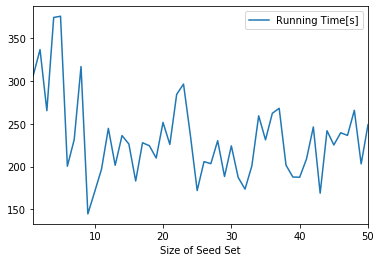

In [23]:
WC_df_seed_time.plot()

In [24]:
run_time["WC"]
# 36880.66751432419
# 12600.19477558136

12582.779662847519

In [25]:
S["WC"]
# [763.0,
#  634.0,
#  5232.0,
#  645.0,
#  71399.0,
#  5227.0,
#  1835.0,
#  3924.0,
#  4920.0,
#  7047.0,
#  1720.0,
#  637.0,
#  5224.0,
#  2969.0,
#  2704.0,
#  1533.0,
#  145.0,
#  1596.0,
#  9412.0,
#  2066.0,
#  770.0,
#  1059.0,
#  44.0,
#  629.0,
#  16248.0,
#  3527.0,
#  6003.0,
#  5144.0,
#  6774.0,
#  71388.0,
#  7392.0,
#  5382.0,
#  3415.0,
#  824.0,
#  1501.0,
#  1669.0,
#  1172.0,
#  7394.0,
#  7687.0,
#  1299.0,
#  492.0,
#  1409.0,
#  7592.0,
#  4931.0,
#  1539.0,
#  546.0,
#  650.0,
#  1225.0,
#  7040.0,
#  2118.0]

[763.0,
 634.0,
 5232.0,
 645.0,
 71399.0,
 5227.0,
 1835.0,
 3924.0,
 4920.0,
 7047.0,
 1720.0,
 637.0,
 5224.0,
 2969.0,
 2704.0,
 1533.0,
 145.0,
 1596.0,
 9412.0,
 2066.0,
 770.0,
 1059.0,
 44.0,
 629.0,
 16248.0,
 3527.0,
 6003.0,
 5144.0,
 6774.0,
 71388.0,
 7392.0,
 5382.0,
 3415.0,
 824.0,
 1501.0,
 1669.0,
 1172.0,
 7394.0,
 7687.0,
 1299.0,
 492.0,
 1409.0,
 7592.0,
 4931.0,
 1539.0,
 546.0,
 650.0,
 1225.0,
 7040.0,
 2118.0]

### TR

In [18]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/TR.csv")
network.head()

,# FromNodeId,ToNodeId,TR
0,0,4,0.10
1,0,5,0.01
2,0,7,0.10
3,0,8,0.01
4,0,9,0.10


In [19]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [20]:
start = time.time()
S["TR"], time_list = compute_MIA_time(G, 50, 1/320)
run_time["TR"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init
u 763.0


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



u 634.0



u 5232.0



u 645.0



u 71399.0



u 5227.0



u 1835.0



u 3924.0



u 4920.0



u 7047.0



u 1720.0



u 637.0



u 5224.0



u 2969.0



u 2704.0



u 1533.0



u 145.0



u 1596.0



u 9412.0



u 2066.0



u 770.0



u 1059.0



u 44.0



u 629.0



u 16248.0



u 3527.0



u 6003.0



u 5144.0



u 6774.0



u 71388.0



u 7392.0



u 5382.0



u 3415.0



u 824.0



u 1501.0



u 1669.0



u 1172.0



u 7394.0



u 7687.0



u 1299.0



u 492.0



u 1409.0



u 7592.0



u 4931.0



u 1539.0



u 546.0



u 650.0



u 1225.0



u 7040.0



u 2118.0


In [ ]:
TR_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
TR_df_seed_time.to_csv("result/Epinions/MIA/TR_df_seed_time.csv")

In [ ]:
TR_df_seed_time.plot()

In [ ]:
run_time["TR"]

In [ ]:
S["TR"]

### P=0.1

In [ ]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/P=0_1.csv")
network.head()

In [19]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [20]:
start = time.time()
S["P=0_1"], time_list = compute_MIA_time(G, 50, 1/320)
run_time["P=0_1"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init
u 763.0


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



u 634.0



u 5232.0



u 645.0



u 71399.0



u 5227.0



u 1835.0



u 3924.0



u 4920.0



u 7047.0



u 1720.0



u 637.0



u 5224.0



u 2969.0



u 2704.0



u 1533.0



u 145.0



u 1596.0



u 9412.0



u 2066.0



u 770.0



u 1059.0



u 44.0



u 629.0



u 16248.0



u 3527.0



u 6003.0



u 5144.0



u 6774.0



u 71388.0



u 7392.0



u 5382.0



u 3415.0



u 824.0



u 1501.0



u 1669.0



u 1172.0



u 7394.0



u 7687.0



u 1299.0



u 492.0



u 1409.0



u 7592.0



u 4931.0



u 1539.0



u 546.0



u 650.0



u 1225.0



u 7040.0



u 2118.0


In [ ]:
P01_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
P01_df_seed_time.to_csv("result/Epinions/MIA/P01_df_seed_time.csv")

In [ ]:
P01_df_seed_time.plot()

In [ ]:
run_time["P=0_1"]

In [ ]:
S["P=0_1"]

### P=0.01

In [ ]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/P=0_01.csv")
network.head()

In [19]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [20]:
start = time.time()
S["P=0_01"], time_list = compute_MIA_time(G, 50, 1/320)
run_time["P=0_01"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init
u 763.0


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



u 634.0



u 5232.0



u 645.0



u 71399.0



u 5227.0



u 1835.0



u 3924.0



u 4920.0



u 7047.0



u 1720.0



u 637.0



u 5224.0



u 2969.0



u 2704.0



u 1533.0



u 145.0



u 1596.0



u 9412.0



u 2066.0



u 770.0



u 1059.0



u 44.0



u 629.0



u 16248.0



u 3527.0



u 6003.0



u 5144.0



u 6774.0



u 71388.0



u 7392.0



u 5382.0



u 3415.0



u 824.0



u 1501.0



u 1669.0



u 1172.0



u 7394.0



u 7687.0



u 1299.0



u 492.0



u 1409.0



u 7592.0



u 4931.0



u 1539.0



u 546.0



u 650.0



u 1225.0



u 7040.0



u 2118.0


In [ ]:
P001_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
P001_df_seed_time.to_csv("result/Epinions/MIA/P001_df_seed_time.csv")

In [ ]:
P001_df_seed_time.plot()

In [ ]:
run_time["P=0_01"]

In [ ]:
S["P=0_01"]

### P=0.001

In [ ]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/P=0_001.csv")
network.head()

In [19]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [20]:
start = time.time()
S["P=0_001"], time_list = compute_MIA_time(G, 50, 1/320)
run_time["P=0_001"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init
u 763.0


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



u 634.0



u 5232.0



u 645.0



u 71399.0



u 5227.0



u 1835.0



u 3924.0



u 4920.0



u 7047.0



u 1720.0



u 637.0



u 5224.0



u 2969.0



u 2704.0



u 1533.0



u 145.0



u 1596.0



u 9412.0



u 2066.0



u 770.0



u 1059.0



u 44.0



u 629.0



u 16248.0



u 3527.0



u 6003.0



u 5144.0



u 6774.0



u 71388.0



u 7392.0



u 5382.0



u 3415.0



u 824.0



u 1501.0



u 1669.0



u 1172.0



u 7394.0



u 7687.0



u 1299.0



u 492.0



u 1409.0



u 7592.0



u 4931.0



u 1539.0



u 546.0



u 650.0



u 1225.0



u 7040.0



u 2118.0


In [ ]:
P0001_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
P0001_df_seed_time.to_csv("result/Epinions/MIA/P0001_df_seed_time.csv")

In [ ]:
P0001_df_seed_time.plot()

In [ ]:
run_time["P=0_001"]

In [ ]:
S["P=0_001"]

# 結果

In [ ]:
pd.DataFrame(S)

In [ ]:
pd.DataFrame([run_time])

In [ ]:
# resultフォルダに保存
pd.DataFrame(S).to_csv("result/Epinions/MIA/seed.csv")
pd.DataFrame([run_time]).to_csv("result/Epinions/MIA/run_time.csv")

## HepPh

In [17]:
run_time = dict([])
S = dict([])

### WC

In [18]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/HepPh/WC.csv")
network.head()

,# FromNodeId,ToNodeId,WC
0,0,4,0.008000
1,0,5,0.005682
2,0,7,0.033333
3,0,8,0.009615
4,0,9,0.066667


In [19]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [20]:
start = time.time()
S["WC"], time_list = compute_MIA_time(G, 50, 1/320)
run_time["WC"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init
u 763.0


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



u 634.0



u 5232.0



u 645.0



u 71399.0



u 5227.0



u 1835.0



u 3924.0



u 4920.0



u 7047.0



u 1720.0



u 637.0



u 5224.0



u 2969.0



u 2704.0



u 1533.0



u 145.0



u 1596.0



u 9412.0



u 2066.0



u 770.0



u 1059.0



u 44.0



u 629.0



u 16248.0



u 3527.0



u 6003.0



u 5144.0



u 6774.0



u 71388.0



u 7392.0



u 5382.0



u 3415.0



u 824.0



u 1501.0



u 1669.0



u 1172.0



u 7394.0



u 7687.0



u 1299.0



u 492.0



u 1409.0



u 7592.0



u 4931.0



u 1539.0



u 546.0



u 650.0



u 1225.0



u 7040.0



u 2118.0


In [22]:
WC_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
WC_df_seed_time.to_csv("result/HepPh/MIA/WC_df_seed_time.csv")

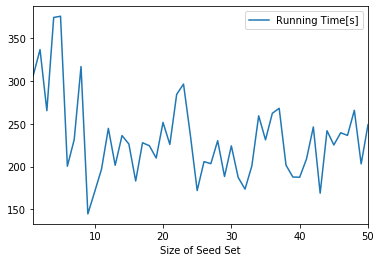

In [23]:
WC_df_seed_time.plot()

In [24]:
run_time["WC"]

12582.779662847519

In [25]:
S["WC"]

[763.0,
 634.0,
 5232.0,
 645.0,
 71399.0,
 5227.0,
 1835.0,
 3924.0,
 4920.0,
 7047.0,
 1720.0,
 637.0,
 5224.0,
 2969.0,
 2704.0,
 1533.0,
 145.0,
 1596.0,
 9412.0,
 2066.0,
 770.0,
 1059.0,
 44.0,
 629.0,
 16248.0,
 3527.0,
 6003.0,
 5144.0,
 6774.0,
 71388.0,
 7392.0,
 5382.0,
 3415.0,
 824.0,
 1501.0,
 1669.0,
 1172.0,
 7394.0,
 7687.0,
 1299.0,
 492.0,
 1409.0,
 7592.0,
 4931.0,
 1539.0,
 546.0,
 650.0,
 1225.0,
 7040.0,
 2118.0]

### TR

In [18]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/HepPh/TR.csv")
network.head()

,# FromNodeId,ToNodeId,TR
0,0,4,0.10
1,0,5,0.01
2,0,7,0.10
3,0,8,0.01
4,0,9,0.10


In [19]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [20]:
start = time.time()
S["TR"], time_list = compute_MIA_time(G, 50, 1/320)
run_time["TR"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init
u 763.0


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



u 634.0



u 5232.0



u 645.0



u 71399.0



u 5227.0



u 1835.0



u 3924.0



u 4920.0



u 7047.0



u 1720.0



u 637.0



u 5224.0



u 2969.0



u 2704.0



u 1533.0



u 145.0



u 1596.0



u 9412.0



u 2066.0



u 770.0



u 1059.0



u 44.0



u 629.0



u 16248.0



u 3527.0



u 6003.0



u 5144.0



u 6774.0



u 71388.0



u 7392.0



u 5382.0



u 3415.0



u 824.0



u 1501.0



u 1669.0



u 1172.0



u 7394.0



u 7687.0



u 1299.0



u 492.0



u 1409.0



u 7592.0



u 4931.0



u 1539.0



u 546.0



u 650.0



u 1225.0



u 7040.0



u 2118.0


In [ ]:
TR_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
TR_df_seed_time.to_csv("result/HepPh/MIA/TR_df_seed_time.csv")

In [ ]:
TR_df_seed_time.plot()

In [ ]:
run_time["TR"]

In [ ]:
S["TR"]

### P=0.1

In [ ]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/HepPh/P=0_1.csv")
network.head()

In [19]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [20]:
start = time.time()
S["P=0_1"], time_list = compute_MIA_time(G, 50, 1/320)
run_time["P=0_1"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init
u 763.0


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



u 634.0



u 5232.0



u 645.0



u 71399.0



u 5227.0



u 1835.0



u 3924.0



u 4920.0



u 7047.0



u 1720.0



u 637.0



u 5224.0



u 2969.0



u 2704.0



u 1533.0



u 145.0



u 1596.0



u 9412.0



u 2066.0



u 770.0



u 1059.0



u 44.0



u 629.0



u 16248.0



u 3527.0



u 6003.0



u 5144.0



u 6774.0



u 71388.0



u 7392.0



u 5382.0



u 3415.0



u 824.0



u 1501.0



u 1669.0



u 1172.0



u 7394.0



u 7687.0



u 1299.0



u 492.0



u 1409.0



u 7592.0



u 4931.0



u 1539.0



u 546.0



u 650.0



u 1225.0



u 7040.0



u 2118.0


In [ ]:
P01_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
P01_df_seed_time.to_csv("result/HepPh/MIA/P01_df_seed_time.csv")

In [ ]:
P01_df_seed_time.plot()

In [ ]:
run_time["P=0_1"]

In [ ]:
S["P=0_1"]

### P=0.01

In [ ]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/HepPh/P=0_01.csv")
network.head()

In [19]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [20]:
start = time.time()
S["P=0_01"], time_list = compute_MIA_time(G, 50, 1/320)
run_time["P=0_01"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init
u 763.0


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



u 634.0



u 5232.0



u 645.0



u 71399.0



u 5227.0



u 1835.0



u 3924.0



u 4920.0



u 7047.0



u 1720.0



u 637.0



u 5224.0



u 2969.0



u 2704.0



u 1533.0



u 145.0



u 1596.0



u 9412.0



u 2066.0



u 770.0



u 1059.0



u 44.0



u 629.0



u 16248.0



u 3527.0



u 6003.0



u 5144.0



u 6774.0



u 71388.0



u 7392.0



u 5382.0



u 3415.0



u 824.0



u 1501.0



u 1669.0



u 1172.0



u 7394.0



u 7687.0



u 1299.0



u 492.0



u 1409.0



u 7592.0



u 4931.0



u 1539.0



u 546.0



u 650.0



u 1225.0



u 7040.0



u 2118.0


In [ ]:
P001_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
P001_df_seed_time.to_csv("result/HepPh/MIA/P001_df_seed_time.csv")

In [ ]:
P001_df_seed_time.plot()

In [ ]:
run_time["P=0_01"]

In [ ]:
S["P=0_01"]

### P=0.001

In [ ]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/HepPh/P=0_001.csv")
network.head()

In [19]:
# numpy型に変換
network_np = network.values

# 空の有向グラフを作成
G = nx.DiGraph()

# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [20]:
start = time.time()
S["P=0_001"], time_list = compute_MIA_time(G, 50, 1/320)
run_time["P=0_001"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init
u 763.0


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



u 634.0



u 5232.0



u 645.0



u 71399.0



u 5227.0



u 1835.0



u 3924.0



u 4920.0



u 7047.0



u 1720.0



u 637.0



u 5224.0



u 2969.0



u 2704.0



u 1533.0



u 145.0



u 1596.0



u 9412.0



u 2066.0



u 770.0



u 1059.0



u 44.0



u 629.0



u 16248.0



u 3527.0



u 6003.0



u 5144.0



u 6774.0



u 71388.0



u 7392.0



u 5382.0



u 3415.0



u 824.0



u 1501.0



u 1669.0



u 1172.0



u 7394.0



u 7687.0



u 1299.0



u 492.0



u 1409.0



u 7592.0



u 4931.0



u 1539.0



u 546.0



u 650.0



u 1225.0



u 7040.0



u 2118.0


In [ ]:
P0001_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
P0001_df_seed_time.to_csv("result/HepPh/MIA/P0001_df_seed_time.csv")

In [ ]:
P0001_df_seed_time.plot()

In [ ]:
run_time["P=0_001"]

In [ ]:
S["P=0_001"]

# 結果

In [ ]:
pd.DataFrame(S)

In [ ]:
pd.DataFrame([run_time])

In [ ]:
# resultフォルダに保存
pd.DataFrame(S).to_csv("result/HepPh/MIA/seed.csv")
pd.DataFrame([run_time]).to_csv("result/HepPh/MIA/run_time.csv")